In [1]:
import os
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import pickle
from sklearn.metrics import f1_score, classification_report
from sklearn.dummy import DummyClassifier
import torch
from transformers import AdamW, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PREFIX = "../../data/"
PA_PATH = PREFIX + "sap2017-connotation-frames-power-agency/"
TT_PATH = PA_PATH + "train-test-splits/"
MODEL_PATH = 'agency_bert_context_models_v3/'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device', device)

device cuda


# test set

In [5]:
with open(TT_PATH + 'test_agency_vp.pickle', 'rb') as f:
    test_vp = pickle.load(f)

In [6]:
pa = pd.read_pickle(PA_PATH + 'power_agency_sents.pkl')
pa = pa[pa.verb_prep.isin(test_vp)]

In [7]:
MASK = '<VERB>'
SEP = '<SEPX>'
def get_mask_w_context(row):
    result = []
    for sent in row.sents:
        string = sent.to_plain_string()
        found = False

        for token in sent:
            if not found and token.get_tag('lemma').value == row.lemma:
                string = token.text + ' ' + SEP + ' ' + string.replace(token.text, MASK) 
                found = True
        result.append(string)
    return result

In [8]:
pa['sents_masked'] = pa.progress_apply(get_mask_w_context, axis=1)

100%|██████████| 419/419 [00:05<00:00, 70.05it/s]


In [9]:
pa = pa.drop('index',axis=1)
pa.reset_index(inplace=True)

In [10]:
X = pa.sents_masked
y = pa.agency.map({'agency_pos': 0, 'agency_equal': 1, 'agency_neg': 2 })

In [11]:
len(X), len(y)

(419, 419)

In [12]:
y.value_counts()

0    326
1     47
2     46
Name: agency, dtype: int64

In [13]:
Xy = pd.concat([X, y], axis=1)

In [14]:
Xy = Xy.explode('sents_masked')

In [15]:
X = Xy['sents_masked']
y = Xy['agency']

In [16]:
len(X), len(y)

(83800, 83800)

## get model

In [17]:
def read_model(save_dir):
    model = BertForSequenceClassification.from_pretrained(save_dir, num_labels=3)
    model.to(device)
    return model

In [18]:
def pred(model, X, batch_size):
    predictions = []
    i1 = 0
    i2 = batch_size
    while i1 < len(X):
        sequences = X[i1:i2]
        batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**batch.to(device))        
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().tolist())

        i1 += batch_size
        i2 += batch_size
        if i2 > len(X):
            i2 = len(X)    
    return predictions

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_added_tokens = tokenizer.add_special_tokens({
    'additional_special_tokens': [MASK, SEP]
})

In [20]:
path = 'agency_bert_context_models_v3/bert-base-uncased 12 20 1e-08'

In [21]:
model = read_model(path)
model.eval()
preds = pred(model, X.tolist(), 250)

{'agency_pos': {'precision': 0.901970781104411, 'recall': 0.7868865030674846, 'f1-score': 0.8405075318845684, 'support': 65200}, 'agency_equal': {'precision': 0.19195428059166292, 'recall': 0.36446808510638296, 'f1-score': 0.25146799765120376, 'support': 9400}, 'agency_neg': {'precision': 0.43291809061845443, 'recall': 0.42684782608695654, 'f1-score': 0.42986152919927756, 'support': 9200}, 'macro avg': {'precision': 0.5089477174381761, 'recall': 0.5260674714202748, 'f1-score': 0.50727901957835, 'support': 83800}}


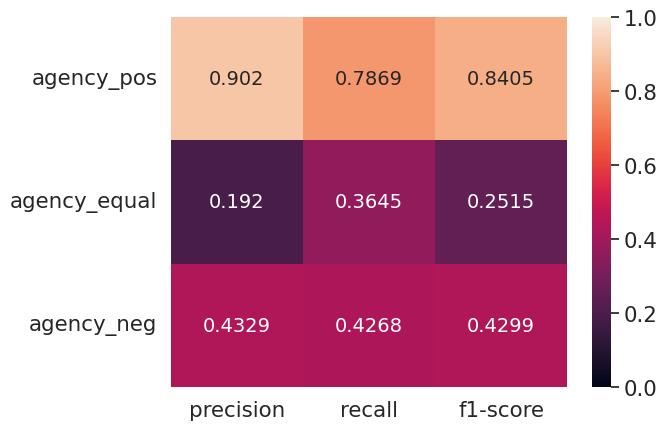

In [22]:
clf_report = classification_report(y.tolist(),
                                   preds,
                                   labels=[0,1,2],
                                   target_names=['agency_pos', 'agency_equal', 'agency_neg'],
                                   output_dict=True,
                                   digits=4)
for key in ['accuracy', 'macro avg', 'weighted avg']:
    del clf_report[key]
print(clf_report)
sns.set(font_scale=1.4) # for label size
sns_plot = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, vmin=0, vmax=1, fmt='.4g', annot_kws={"size": 14})
sns_plot.figure.savefig('clf_reports/' + path.split('/')[1] + ".png", bbox_inches='tight')
plt.show()

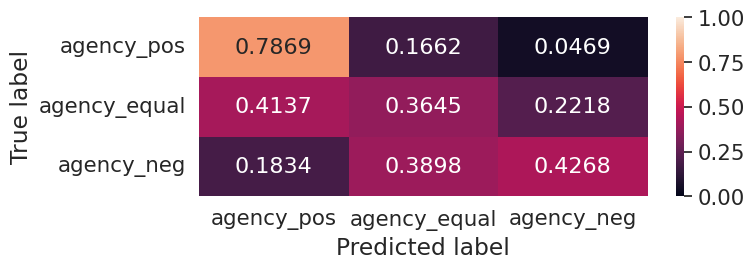

In [23]:
cm_arr = confusion_matrix(y.tolist(), preds, normalize='true')
df_cm = pd.DataFrame(cm_arr, range(3), range(3))
df_cm.columns=['agency_pos', 'agency_equal', 'agency_neg']
df_cm.index=['agency_pos', 'agency_equal', 'agency_neg']

plt.figure(figsize=(8,3))
sns.set(font_scale=1.4) # for label size
sns_plot = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.4f', vmin=0, vmax=1) 
plt.ylabel('True label', )
plt.xlabel('Predicted label')
plt.tight_layout()
sns_plot.figure.savefig('confusion_mtx/' + path.split('/')[1] + ".png", bbox_inches='tight')

plt.show()

# dummy

In [24]:
with open(TT_PATH + 'train_agency_vp.pickle', 'rb') as f:
    train_vp = pickle.load(f)

In [25]:
pa_train = pd.read_pickle(PA_PATH + 'power_agency_sents.pkl')
pa_train = pa_train[pa_train.verb_prep.isin(train_vp)]

In [26]:
pa_train.head()

,index,verb,agency,power,verb_prep,prep,lemma,sents
1,1,abolishes,agency_pos,power_agent,abolishes,NaN,abolish,"[(Token: 1 delivering, Token: 2 a, Token: 3 st..."
2,2,absorbs,agency_pos,power_agent,absorbs,NaN,absorb,"[(Token: 1 Lexx, Token: 2 was, Token: 3 co-pro..."
3,3,abuses,agency_pos,power_agent,abuses,NaN,abuse,"[(Token: 1 potanin, Token: 2 ', Token: 3 s, To..."
4,4,accelerates,agency_pos,power_agent,accelerates,NaN,accelerate,"[(Token: 1 You, Token: 2 ca, Token: 3 n't, Tok..."
5,5,accepts,agency_neg,power_agent,accepts,NaN,accept,"[(Token: 1 Perhaps, Token: 2 he, Token: 3 will..."


In [27]:
pae_train = pa_train.explode('sents')

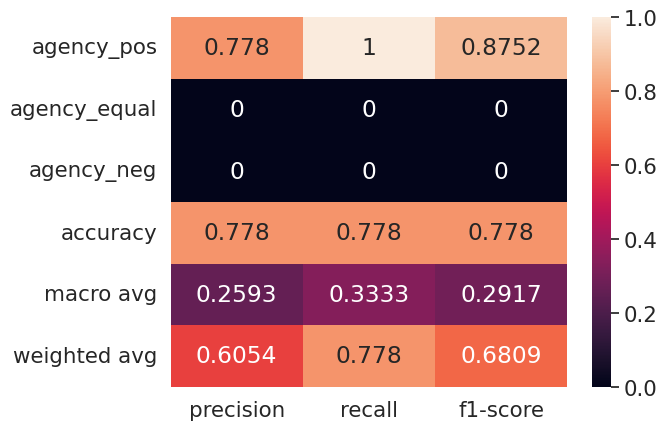

In [28]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(pae_train.sents, pae_train.agency.map({'agency_pos': 0, 'agency_equal': 1, 'agency_neg': 2 }))
preds = dummy_clf.predict(X.tolist())

clf_report = classification_report(y.tolist(),
                                   preds,
                                   labels=[0,1,2],
                                   target_names=['agency_pos', 'agency_equal', 'agency_neg'],
                                   output_dict=True,
                                   digits=4)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, vmin=0, vmax=1, fmt='.4g')
plt.show()

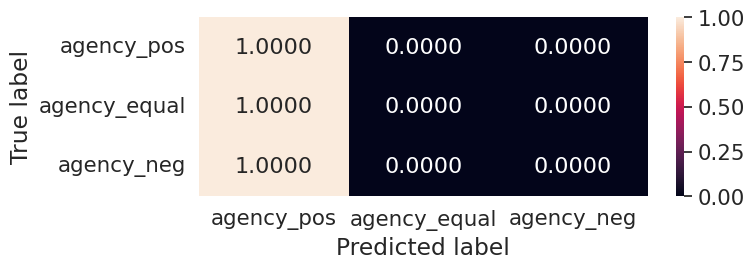

In [30]:
cm_arr = confusion_matrix(y.tolist(), preds, normalize='true')
df_cm = pd.DataFrame(cm_arr, range(3), range(3))
df_cm.columns=['agency_pos', 'agency_equal', 'agency_neg']
df_cm.index=['agency_pos', 'agency_equal', 'agency_neg']

plt.figure(figsize=(8,3))
sns.set(font_scale=1.4) # for label size
sns_plot = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.4f', vmin=0, vmax=1) 
plt.ylabel('True label', )
plt.xlabel('Predicted label')
plt.tight_layout()
sns_plot.figure.savefig('confusion_mtx/majority.png', bbox_inches='tight')

plt.show()